<a id = "table-of-content"></a>
# Table of Contents

1. [Introduction](#1.-Introduction) <br>
    [1.1 About the Dataset](#1.1-About-the-Dataset)
2. [EDA & Data Preprocessing](#2.-EDA-and-Data-Preprocessing) <br>
    [2.1 Importing Libraries and Data](#2.1-Importing-Libraries-and-Data) <br>
    [2.2 EDA](#2.2-EDA) <br>
    [2.3 Data Preprocessing](#2.3-Data-Preprocessing)
3. [Model Selection](#3.-Model-Selection)
4. [Model Training](#4.-Model-Training)
5. [Model Evaluation](#5.-Model-Evaluation)
6. [Model Prediction](#6.-Model-Prediction)
7. [Conclusion](#7.-Conclusion)

## 1. Introduction

Rice is one of the most important crops in the world, providing food for more than half of the global population. However, nitrogen deficiency is a significant problem in the rice farming sector as it can affect the growth, yield and quality of the crops, leading to economic losses for farmers. The ability to detect nitrogen deficiency in crops early on can help farmers take necessary actions to improve the yield and prevent loss of crops. One of the most common signs of nitrogen deficiency in plants is leaf chlorosis(*yellowing of leaves*), which can lead to stunted growth and reduced yield. Nitrogen fertilization is a common practice among farmers to ensure optimal plant growth and maximize crop yield. However, over-fertilization can lead to environmental pollution and soil degradation, which is not an uncommon case amongst small time farmers. As a result, it is essential to monitor nitrogen levels in crops and apply fertilizers efficiently for both environmental and economical reasons. Traditional methods for detecting nitrogen deficiency, such as the leaf color chart (LCC), can be subjective due to different observers(human error), leading to inaccurate results.

To overcome these challenges, this project aims to digitalize the LCC method using deep learning techniques to automate the detection of nitrogen deficiency in rice plants. This approach can provide more accurate and efficient results, allowing farmers to make informed decisions about fertilization and ultimately increase crop yield and quality. The aim of this project is to provide an affordable and accessible tool for farmers to monitor nitrogen levels in their crops without relying on expensive and high-end technologies. With this model, farmers can detect nitrogen deficiency early, allowing them to apply fertilizers efficiently and prevent losses/maximize yields, while being environmentally friendly and sustainable.

The project involves tapping on a pre-trained EfficientNet model on a dataset of rice plant images labeled with nitrogen deficiency levels. The model's performance will be evaluated based on F1-score.

In addition to modifying the model for detecting nitrogen deficiency, this project also involves building a predictor function that can make predictions on new images. This function can be used to test the model's accuracy on a holdout dataset and also used in real-world applications by farmers and researchers.

In the following sections, we will describe the data collection process, data preprocessing steps, model architecture, training and validation process, and model evaluation. Finally, we will provide instructions on how to use the model to make predictions on new images.




### 1.1 About the Dataset


The dataset used in this study comprises images of nitrogen deficient rice crop leaves that are matched with a leaf color chart, and was obtained from Sambalpur University. 
The LCC method was developed by the International Rice Research Institute (IRRI) and has been adopted by several countries, including Bangladesh, China, India, Indonesia, the Philippines, Thailand, and Vietnam. This method is a simple and low-cost tool for farmers to assess the nitrogen status of rice plants, which can help them to make better decisions regarding the application of fertilizers. However,one potential disadvantage of the Leaf Color Chart (LCC) method is that it relies on human perception and judgment, which can lead to variability in results between different observers. Using the LCC method requires training and practice to achieve consistent and accurate results, which inexperienced/new farmers may lack, hence we are exploring the usage of computer vision to help bridge this gap. 


The images in this dataset are categorized into subgroups based on their LCC value.

The dataset is organized into four subfolders, each representing a different level of nitrogen deficiency according to the leaf color chart. The objective is to accurately classify the test data into one of the four nitrogen deficiency labels.

----

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rice-leaf-test/googleimage4.jpg
/kaggle/input/rice-leaf-test/unknown3.jpg
/kaggle/input/rice-leaf-test/googleimage5.jpg
/kaggle/input/rice-leaf-test/googleimage3.jpg
/kaggle/input/rice-leaf-test/googleimage9.jpg
/kaggle/input/rice-leaf-test/googleimage6.jpg
/kaggle/input/rice-leaf-test/googleimage7.jpg
/kaggle/input/rice-leaf-test/googleimage2.jpg
/kaggle/input/rice-leaf-test/googleimage1.jpg
/kaggle/input/rice-leaf-test/unknown2.jpg
/kaggle/input/rice-leaf-test/googleimage8.jpg
/kaggle/input/rice-leaf-test/unknown4.jpg
/kaggle/input/rice-leaf-test/unknown1.jpg
/kaggle/input/nitrogen-deficiency-for-rice-crop/NitrogenDeficiencyImage/Training/swap3/SWAP_TR3_460.jpg
/kaggle/input/nitrogen-deficiency-for-rice-crop/NitrogenDeficiencyImage/Training/swap3/SWAP_TR3_092.jpg
/kaggle/input/nitrogen-deficiency-for-rice-crop/NitrogenDeficiencyImage/Training/swap3/SWAP_TR3_1399.jpg
/kaggle/input/nitrogen-deficiency-for-rice-crop/NitrogenDeficiencyImage/Training/swap3/SWAP_TR3_1369.jpg


## 2. EDA and Data Preprocessing

Our dataset, gathered by the university, is by default cleaned and organized. Before we can begin training our machine learning model, we need to prepare the data by loading and preprocessing the images. We will use PyTorch's built-in torchvision package to load and transform the images.


## 2.1 Importing Libraries and Data

We will first load all necessary packages and our dataset. Also adding a GPU option for training if available on device. 

In [2]:
# Importing all libraries we will be using

import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
import sys, random, os, cv2, json, math
import seaborn as sns
import numpy as np
from sklearn.metrics import *
from torchvision import transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image

In [3]:
# Enabling GPU if possible, otherwise use CPU

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

We define a function to read and split our data into training and holdout sets from a root directory.

In [4]:
# Defining where training data is stored
root = '/kaggle/input/nitrogen-deficiency-for-rice-crop/NitrogenDeficiencyImage/Training/'

# Defining a read/split data function that takes in the 'root' directory and boolean plot_image as arguement
def read_split_data(root, plot_image=False): # setting 'plot_image' to false as there are thousands of images in the folder
    filepaths = [] # initialize empty list to store image filepath
    labels = [] # initialize empty list to store image labels
    bad_images = []  # initialize empty list to store corrupted/unreadable images

    random.seed(0)
    assert os.path.exists(root), 'path does not exist!' # checks if directory exists otherwise return error message

    # map class labels to numerical indices
    classes = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
    classes.sort()
    class_indices = {k: v for v, k in enumerate(classes)}

    json_str = json.dumps({v: k for k, v in class_indices.items()}, indent=4)

    with open('classes_indices.json', 'w') as json_file:
        json_file.write(json_str)

    every_class_num = [] # create an empty list to store the number of images in each class
    supported = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG'] # supported image file extensions

    for klass in classes: # iterate over classes
        classpath = os.path.join(root, klass) # form the path to the current class directory
        images = [os.path.join(root, klass, i) for i in os.listdir(classpath) if os.path.splitext(i)[-1] in supported] # get the paths of all images in the current class directory that have a supported file extension
        every_class_num.append(len(images)) # append the number of images in the current class to the every_class_num list
        flist = sorted(os.listdir(classpath)) # get a sorted list of all the files in the current class directory
        desc = f'{klass:23s}' # set the description string for the tqdm progress bar
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'): # iterate over all the files in the current class directory using tqdm progress bar
            fpath = os.path.join(classpath, f) # form the path to the current file
            fl = f.lower() # convert file name to lower case
            index = fl.rfind('.') # find the index of the file extension
            ext = fl[index:] # get the file extension
            if ext in supported: # if the file extension is supported
                try:
                    img = cv2.imread(fpath) # read image
                    filepaths.append(fpath) # append the path of image to filepaths list
                    labels.append(klass) # append the class of the image to the labels list
                except:
                    bad_images.append(fpath) # append the path of the defective image to the bad_images list
                    print('defective image file: ', fpath) # print a message indicating that the image is defective
            else:
                bad_images.append(fpath) # append the path of the unsupported image to the bad_images list
    Fseries = pd.Series(filepaths, name='filepaths') # create a pandas Series object for the filepaths
    Lseries = pd.Series(labels, name='labels') # create a pandas Series object for the labels
    df = pd.concat([Fseries, Lseries], axis=1) # concatenate the filepaths and labels Series objects into a pandas DataFrame
    print(f'{len(df.labels.unique())} kind of images were found in the dataset') # print the number of unique classes in the dataset

    # splitting into training and testing dataset, stratifying since it is a classification problem
    train_df, test_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])

    train_image_path = train_df['filepaths'].tolist() # extract the filepaths for the images in the training set and convert them into a list.
    val_image_path = test_df['filepaths'].tolist() # extract the filepaths for the images in the testing set and convert them into a list.


    train_image_label = [class_indices[i] for i in train_df['labels'].tolist()] # map the labels in the training set to their corresponding class indices using a dictionary called class_indices
    val_image_label = [class_indices[i] for i in test_df['labels'].tolist()] # map the labels in the testing set to their corresponding class indices using the same class_indices dictionary

    sample_df = train_df.sample(n=50, replace=False) # take a random sample of 50 images from the training set without replacement.
    ht, wt, count = 0, 0, 0 # initialize variables ht, wt, and count to zero.
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i] # get the file path of the i-th image in the sample data frame
        try:
            img = cv2.imread(fpath) # read the image from the file path using OpenCV
            h = img.shape[0] # get height of image
            w = img.shape[1] # get width of image
            ht += h # add height of image to height variable
            wt += w # add width of image to image variable
            count += 1 # increment count variable and track number of images 
        except:
            pass
    have = int(ht / count) # calculate the average height of the sample images by dividing the total height by the number of images and converting the result to an integer
    wave = int(wt / count) # calculates the average width of the sample images by dividing the total width by the number of images and converting the result to an integer.
    aspect_ratio = have / wave # calculates the aspect ratio of the sample images by dividing the average height by the average width
    print('{} images were found in the dataset.\n{} to use for training, {} to use for validation'.format(
        sum(every_class_num), len(train_image_path), len(val_image_path)
    ))
    
    # print the total number of images in the dataset, the number of images in the training set, and the number of images in the testing set.
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)

    if plot_image:
        plt.bar(range(len(classes)), every_class_num, align='center') # generate a bar chart with the number of images for each class
        plt.xticks(range(len(classes)), classes)

        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha='center') # add the number of images for each class as a label above the corresponding bar.

        plt.xlabel('image class')
        plt.ylabel('number of images')

        plt.title('class distribution')
        plt.show()

    return train_image_path, train_image_label, val_image_path, val_image_label, class_indices

## 2.2 EDA 

We can now load our data and get a feel of how our dataset details looks like. 

swap4                  : 100%|█████████████████████████████████████████| 1380/1380 [00:10<00:00, 130.90file/s]


4 kind of images were found in the dataset
5390 images were found in the dataset.
4312 to use for training, 1078 to use for validation
average image height=  96   average image width=  94  aspect ratio h/w=  1.0212765957446808


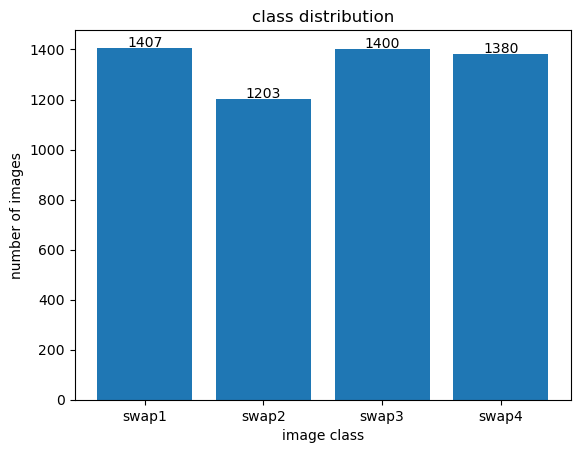

In [5]:
# Load data
train_image_path, train_image_label, val_image_path, val_image_label, class_indices = read_split_data(root, plot_image=True)

There are 4 classes found amongst 5390 images and our data is quite balanced in each category. We have split the data into training and holdout sets, 4312 and 1078 images respectively.  

Let's look at some sample images.

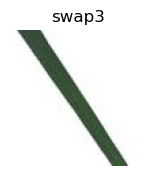

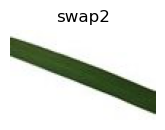

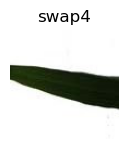

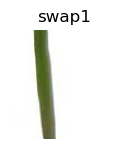

In [42]:
# Define the class names for your dataset
class_labels = os.listdir(root)

# Plot some sample images from the dataset
plt.figure(figsize=(15, 6))
for i in range(4):
    ax = plt.subplot(3,3,i+1)
    img_path = os.path.join(root, class_labels[i], os.listdir(os.path.join(root, class_labels[i]))[0])
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(class_labels[i])
    plt.axis('off')
    plt.show()


## 2.3 Data Preprocessing
Creating some pipelines to use for modelling later on. 

Creating a class to manipulate the data.

In [7]:
# creating a class to manipulate data
class MyDataset(Dataset):
    def __init__(self, image_path, image_labels, transforms=None):
        self.image_path = image_path # save the list of image paths to an instance variable.
        self.image_labels = image_labels # save the list of image labels to an instance variable
        self.transform = transforms # save the data transformation object to an instance variable. 
        
    def __len__(self):
        return len(self.image_path) # return the length of the image_path list
    
    def __getitem__(self, idx): 
        image = Image.open(self.image_path[idx]).convert('RGB') # open image from the image_path list and convert to RGB format
        label = self.image_labels[idx] # retrieve the label for the corresponding image.
        if self.transform:
            image = self.transform(image) # apply provided transformations to the image.
        return image, label # return transformed image and corresponding label as tuple
    
    @staticmethod
    def collate_fn(batch): # combine list of data points into mini-batch
        images, labels = tuple(zip(*batch)) # separate the images and labels in a batch and converts them to tuples
        images = torch.stack(images, dim=0) # stack images into a tensor
        labels = torch.as_tensor(labels) # converts labels to a tensor
        return images, labels # returns stacked images and corresponding labels as a tuple

We now define the image transformations to be applied to the dataset. We will resize each image to 100x100 pixels and normalize the pixel values using the mean and standard deviation of the ImageNet dataset. This step is important to ensure that the pixel values are within a certain range, which helps to improve the accuracy of the model.

In [8]:
# Creating a transformation pipeline for the datasets 
data_transform = {
    'train': transforms.Compose([transforms.RandomResizedCrop(100), # randomly crop and resize the image to 100x100
                                 transforms.ToTensor(), # convert the image to a PyTorch tensor
                                 transforms.RandomHorizontalFlip(), # randomly flip the image horizontally
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]), # normalize the image with the mean and standard deviation values for each color channel
    
    'valid': transforms.Compose([transforms.Resize((100, 100)), # resize the image to 100x100
                                 transforms.CenterCrop(100), # crop the center of the image
                                 transforms.ToTensor(), # convert the image to a PyTorch tensor
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) # normalize the image with the mean and standard deviation values for each color channel

}

---

# 3. Model Selection
We will be using the EfficientNet-B4 pre-trained model. EfficientNet is a family of convolutional neural networks that have been scaled based on a compound scaling method that uniformly scales the depth/width/resolution of the neural network. EfficientNet-B4 is one of the larger models in the family and has achieved state-of-the-art performance on several computer vision tasks.

We will be using the pre-trained model as a feature extractor, where we will remove the last layer of the model and replace it with a fully connected layer that will act as the output layer of our classifier. The pre-trained weights of the model will be frozen during training, which means that we will only be training the output layer of the model.

To use the EfficientNet-B4 model in our project, we will be using the PyTorch implementation of the model provided by the torchvision package. We will download the pre-trained weights of the model and initialize a new instance of the model with the downloaded weights. We will then modify the last layer of the model to have the same number of output units as the number of classes in our dataset.

In addition to the pre-trained model, we will also be using the Adam optimizer with a learning rate of 0.001 and the cross-entropy loss function to train the output layer of the model.

In [9]:
# Initialize pre-trained EfficientNetB4 model
net = models.efficientnet_b4(pretrained=True).to(device)

# Modifying classifier layer 
net.classifier = nn.Sequential(nn.Dropout(0.5, inplace=True),  # to reduce overfitting
                               nn.Linear(1792, 512, bias=False), # fully connected layer with 1792 input features and 512 output features based on pre-trained model and dataset
                               nn.BatchNorm1d(512), # batch normalization layer to normalize input to next activation function for speed and stability of training
                               nn.ReLU(inplace=True), # activation function applied element-wise to output of batch normalization layer
                               nn.Linear(512, 4)).to(device) #fully connected linear layer is added with 512 input features and 4 output features, corresponding to the number of output classes.

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

In [10]:
# setting up hyperparameters for model training

batch_size=16
epochs=20
best_val_acc = 0.0

save_path='./EfficientNet_B4NO2Model_1.pt' # The file path to save the trained model

loss_function = nn.CrossEntropyLoss() # defining loss function
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0005) # defining the optimizer parameters



Processing data for training and testing of model using pipelines created.

In [11]:
# creating PyTorch datasets and dataloaders to load training and testing data in batches

train_dataset = MyDataset(train_image_path, train_image_label, data_transform['train']) # create a training dataset object
train_num = len(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, # creating a dataloader to load training data in batches 
                          num_workers=0, collate_fn=train_dataset.collate_fn)

valid_dataset = MyDataset(val_image_path, val_image_label, data_transform['valid']) # creating a testing datset object
valid_num = len(valid_dataset)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, # creating a dataloader to load testing data in batches
                          collate_fn=valid_dataset.collate_fn)

---

# 4. Model Training

To train the model, we will loop over the dataset multiple times, computing the loss on each minibatch of training data, and updating the model parameters accordingly. In addition, we will validate the model on a separate dataset to evaluate its performance.

In [21]:
# Create empty lists to store the training loss, training accuracy, and validation accuracy values
train_Loss, train_Acc, val_Acc = [], [], []

# Create a counter and patience variable to use for Early Stopping 
counter = 0 
patience = 5 #set the number of epochs to wait before stopping

# Loop through each epoch and initialize three variables that will be used to keep track of the running loss, training accuracy, and validation accuracy.
for epoch in range(epochs):
    running_loss, train_acc, val_acc = 0, 0, 0
    
    net.train() # setting network in training mode
    train_bar = tqdm(train_loader, file=sys.stdout, colour='red') # initialize progress bar
    for step, data in enumerate(train_bar):
        images, labels = data # getting batch of training data
        images, labels = images.to(device), labels.to(device) # enabling for GPU usage if available
        optimizer.zero_grad()# reset the gradients to zero before backpropagation
        outputs = net(images) # feed the training data to the network and compute outputs
        loss = loss_function(outputs, labels) # compute the loss between the predicted outputs and the true labels
        running_loss += loss.item() # update running loss for each epoch
        train_acc += (torch.argmax(outputs, dim=1) == labels).sum().item() # update training accuracy for each epoch
        loss.backward() # compute the gradients of the loss with respect to the network parameters
        optimizer.step() # update the network parameters with the computed gradients
        train_bar.desc = f'train epoch [{epoch+1}/{epochs}] train_loss: {(loss.item()):.3f}' # update the progress bar description with the current epoch and loss.
                
    
    net.eval() # set network to evaluation mode
    with torch.no_grad(): # disabling gradient calculation
        val_bar = tqdm(valid_loader, file=sys.stdout, colour='red') # create progress bar
        for data in val_bar:
            # load testing data to GPU/CPU
            images, labels = data  
            images, labels = images.to(device), labels.to(device) 
            
            # compute the predicted outputs for the images and compares them to the labels to compute the testing accuracy
            outputs = net(images) 
            val_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()
    
    # Compute the training accuracy, testing accuracy, and training loss for the current epoch.
    train_accuracy = train_acc / train_num
    val_accuracy = val_acc / valid_num
    train_loss = running_loss / train_num
    
    # Append training loss, training accuracy, and testing accuracy to their respective lists.
    train_Loss.append(train_loss)
    train_Acc.append(train_accuracy)
    val_Acc.append(val_accuracy)
    
       
    # Update the best testing accuracy and saves the model's parameters if the testing accuracy for the current epoch is higher than the best testing accuracy so far.
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(net.state_dict(), save_path)
        counter =0 # reset counter if there's improvement
    else:
        counter += 1 # increment counter if there's no improvement
        
    if counter == patience:
        print(f'No improvemnets after {patience} epochs, early stopping training.')
        
    print(f'epoch [{epoch+1}/{epochs}], train_loss: {train_loss:.3f}, train_accuracy: {train_accuracy:.3f}, valid_accuracy: {val_accuracy:.3f}')
    

print('Finish Training')

100%|██████████| 68/68 [00:03<00:00, 17.98it/s]
epoch [1/20], train_loss: 0.010, train_accuracy: 0.950, valid_accuracy: 0.993
100%|██████████| 68/68 [00:02<00:00, 23.51it/s]
epoch [2/20], train_loss: 0.010, train_accuracy: 0.949, valid_accuracy: 0.997
100%|██████████| 68/68 [00:02<00:00, 22.74it/s]
epoch [3/20], train_loss: 0.010, train_accuracy: 0.956, valid_accuracy: 0.994
100%|██████████| 68/68 [00:03<00:00, 21.85it/s]
epoch [4/20], train_loss: 0.008, train_accuracy: 0.959, valid_accuracy: 0.998
100%|██████████| 68/68 [00:03<00:00, 22.02it/s]
No improvemnets after 5 epochs, early stopping training.
epoch [5/20], train_loss: 0.010, train_accuracy: 0.953, valid_accuracy: 0.994
100%|██████████| 68/68 [00:02<00:00, 22.90it/s]
epoch [6/20], train_loss: 0.009, train_accuracy: 0.956, valid_accuracy: 0.992
100%|██████████| 68/68 [00:02<00:00, 24.77it/s]
epoch [7/20], train_loss: 0.009, train_accuracy: 0.953, valid_accuracy: 0.962
100%|██████████| 68/68 [00:02<00:00, 24.79it/s]
epoch [8/20],

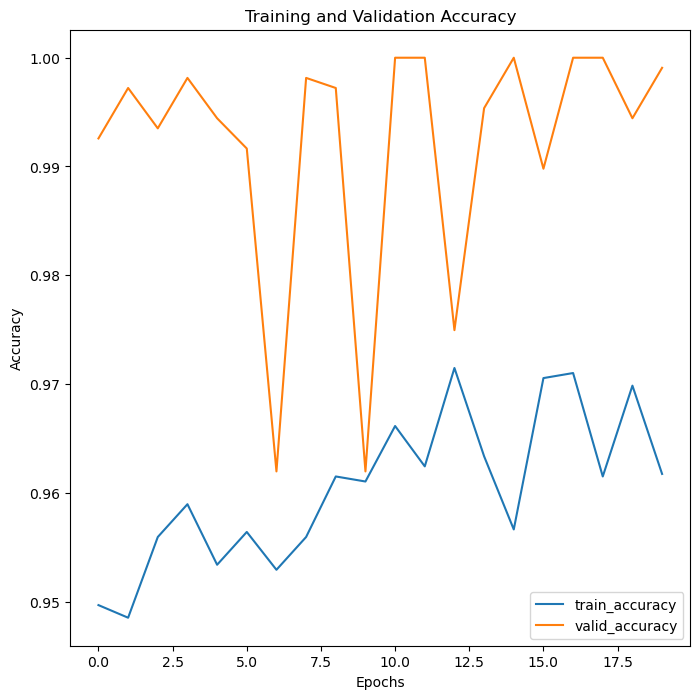

In [43]:
# plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.plot(train_Acc, label='train_accuracy')
plt.plot(val_Acc, label='valid_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


---

# 5. Model Evaluation

After training the model, we need to evaluate its performance on the holdout set to see how well it can generalize to new, unseen data.

To evaluate the model, we'll loop through the holdout dataset and accumulate the predicted labels and actual labels into separate lists. We'll then use scikit-learn's classification_report function to generate a report containing various metrics such as precision, recall, and F1-score for each class as well as an overall accuracy score. We will also plot a confusion matrix for visualization. 

there were 49 errors in 1078 tests for an accuracy of  95.45%
The F1-score was 95.436


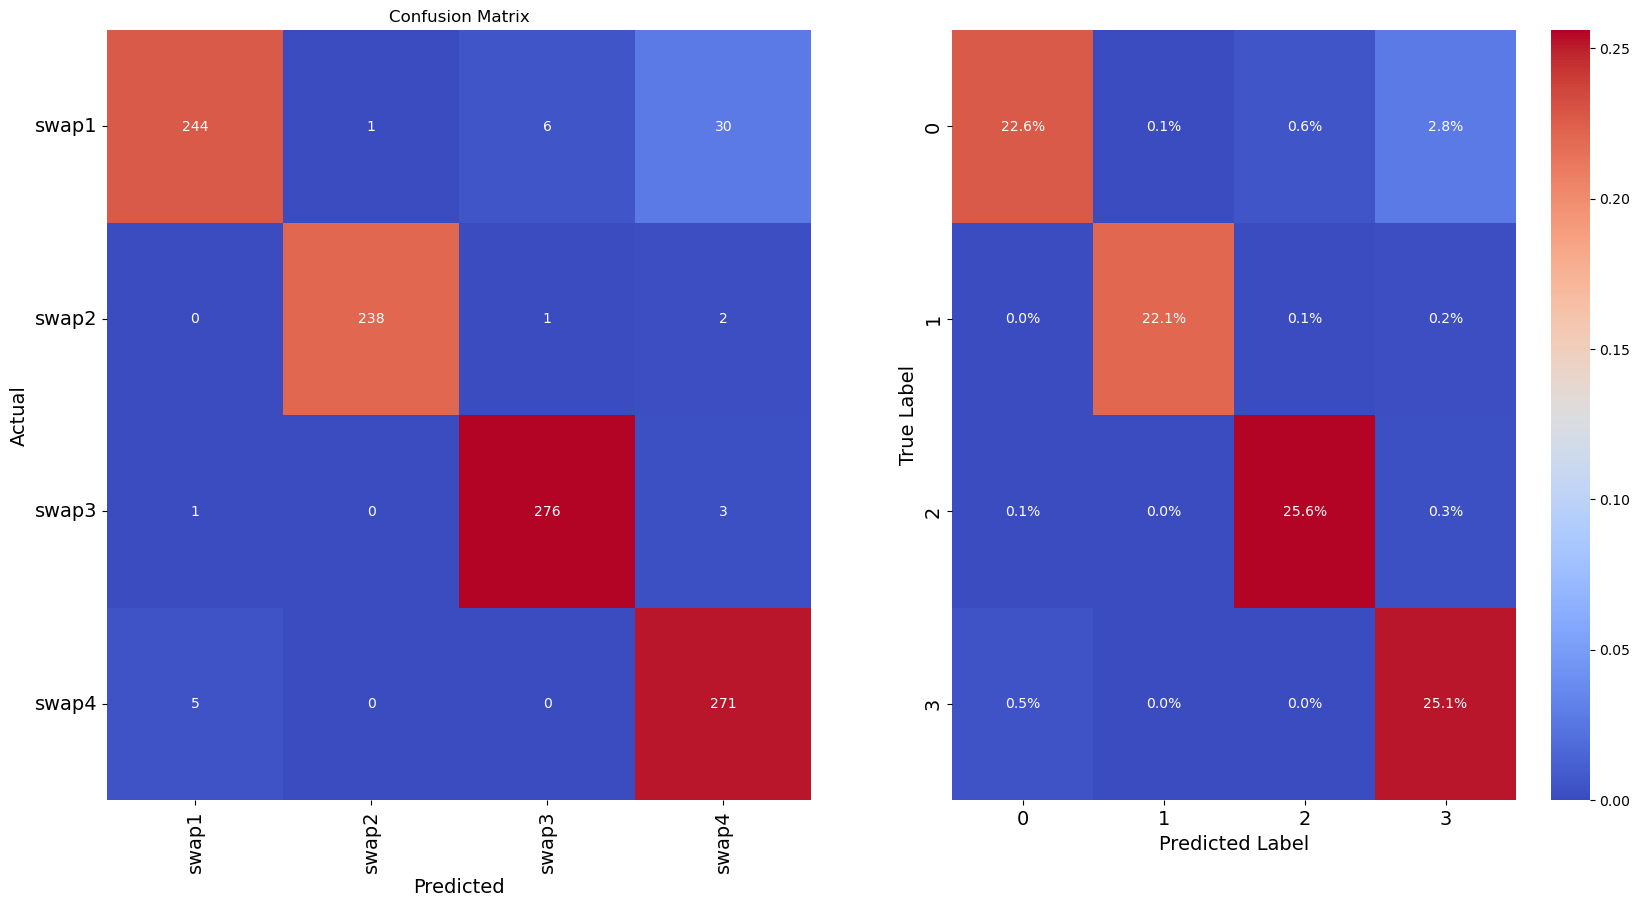

Classification Report:
----------------------
               precision    recall  f1-score   support

       swap1     0.9760    0.8683    0.9190       281
       swap2     0.9958    0.9876    0.9917       241
       swap3     0.9753    0.9857    0.9805       280
       swap4     0.8856    0.9819    0.9313       276

    accuracy                         0.9545      1078
   macro avg     0.9582    0.9559    0.9556      1078
weighted avg     0.9571    0.9545    0.9544      1078



In [23]:
# Attempt to open a JSON file named classes_indices.json for reading
try:
    json_file = open('./classes_indices.json', 'r') 
    class_indict = json.load(json_file) # load file contents into a dictionary variable named class_indict 
except Exception as e:
    print(e) # print error message if unable to open file or encounters exception
    exit(-1) # exit program with status code -1

# Defining a predictor function 
def predictor(testloader):
    errors = 0 # initialize error variable with value 0
    y_pred, y_true = [], [] # creating lists for predictions and true labels 
    
    assert os.path.exists(save_path)
    net.load_state_dict(torch.load(save_path)) # load trained model
    
    net.eval()  # set model to evaluation mode
    with torch.no_grad(): # disabling gradient calculation
        for data in testloader:
            # load data to GPU/CPU
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # using trained model to predict batch of images
            preds = torch.argmax(torch.softmax(net(images), dim=0), dim=1)
            for i in range(len(preds)):
                y_pred.append(preds[i].cpu())
                y_true.append(labels[i].cpu())
    
    tests = len(y_pred)
    for i in range(tests):
        pred_index = y_pred[i] # get predicted label index at position i in the list
        true_index = y_true[i] # get true label index at position i in the list
        if pred_index != true_index:
            errors += 1 # increase number of errors
    acc = (1 - errors / tests) * 100 # calculate accuracy
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%')

    ypred = np.array(y_pred) # convert the list of predicted labels to a numpy array
    ytrue = np.array(y_true) # convert the list of true labels to a numpy array
    
    f1score = f1_score(ytrue, ypred, average='weighted') * 100 # get F1-score 
    print(f'The F1-score was {f1score:.3f}') 
    
    class_count = len(list(class_indict.values()))   # get number of classes
    classes = list(class_indict.values()) # get list of class names
    
    # plot a confusion matrix
    cm = confusion_matrix(ytrue, y_pred)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='coolwarm', cbar=False)
    plt.xticks(np.arange(class_count) + .5, classes, rotation=90, fontsize=14)
    plt.yticks(np.arange(class_count) + .5, classes, rotation=0, fontsize=14)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.title("Confusion Matrix")

    plt.subplot(1, 2, 2)
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.1%', cmap='coolwarm')
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)
    
    return f1score


f1score = predictor(valid_loader)

From our confusion matrix, we can observe that our model's performance on identifying class 0 and 1 is slightly weaker than 2 & 3. However overall the accuracy is still good looking at our classification report.  

In [24]:
from sklearn.metrics import f1_score

# Set the model to evaluation mode
net.eval()

train_preds = []
train_labels = []

# Iterate through the batches in the training data loader
for batch in train_loader:
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = net(images)
    _, preds = torch.max(outputs.data, 1)
    
    train_preds.extend(preds.cpu().numpy())
    train_labels.extend(labels.cpu().numpy())

train_f1 = f1_score(train_labels, train_preds, average='macro')
print('Training F1-score:', train_f1)


Training F1-score: 0.9730864020870915


F1-score for our trained model is 0.973 for train dataset while our holdout set is slightly lower at 0.955. I think this is an acceptable range since its only less than 0.02 difference in their F1-scores. 

---

# 6. Model Prediction

We will define a function to make predictions with the final model for real world usage. Then we can test it out with new images. 

In [16]:
# Define a function to make predictions with the trained model
def predict(model, image_path):
    # Load the image and transform it to the appropriate format
    transform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    # Make a prediction with the trained model
    model.eval()
    with torch.no_grad():
        output = model(image)
        class_index = torch.argmax(output, dim=1).item()

    # Map the predicted index to the class name
    class_names = ['class1', 'class2', 'class3', 'class4']
    class_name = class_names[class_index]

    return class_name

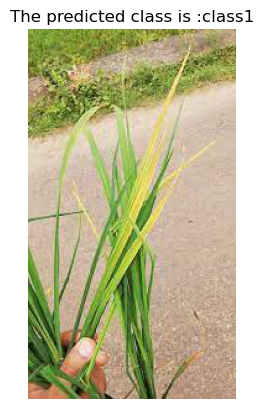

In [17]:
# Example usage: predict the class of a new image
image_path = "/kaggle/input/rice-leaf-test/googleimage1.jpg"
class_name = predict(net, image_path)
image_show = Image.open(image_path)
plt.imshow(image_show)
plt.title('The predicted class is :' + class_name)
plt.axis('off')
plt.show()

---

# 7. Conclusion 

The purpose of this project was to develop a model that can accurately classify rice plant images into the different stages of nitrogen deficiency. We used the EfficientNet_B4 pre-trained model as the base model and fine-tuned it using transfer learning. The dataset was split into 80% training and 20% holdout sets, and we trained the model for 20 epochs with a batch size of 16, using the Adam optimizer and a learning rate of 0.001. The model was evaluated on the holdout set, achieving an accuracy of a F1 score of 95.5%.

Based on the evaluation results, we can conclude that the model performs well in classifying rice plant images into different nitrogen deficiency levels. However, there is still room for improvement. For example, we could experiment with different model architectures, hyperparameters, and data augmentation techniques to further improve the model's performance. Additionally, we could explore the use of object detection to identify the plant amidst disrupting background before classifying for NO2 deficiency, or expand the model to detect for other types of plant diseases with more data. 

In summary, this project demonstrates the potential of deep learning and transfer learning techniques in the field of agriculture. By accurately identifying nitrogen-deficient crops, farmers can take appropriate measures to address this common issue more accurately and efficiently, thus improving their crop yields and quality. 
